In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
import keras
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import argparse

# LOADING AND PROCESSING DATASET

In [2]:
image_list = []
label_list = []

dim = (128, 128)

replay_path = '/kaggle/input/antispoofing-replay-dataset/samples'
printout_live_selfie = '/kaggle/input/printout/live_selfie'
printout_live_video = '/kaggle/input/printout/live_video'
printout_attack = '/kaggle/input/printout/attack'
anti_live = '/kaggle/input/anti-spoofing-live/samples'
train_dir = '/kaggle/input/datacam-extra/Extra Dataset/train'
test_dir = '/kaggle/input/datacam-extra/Extra Dataset/test'
train_color = '/kaggle/input/casia-fasd/CASIA FASD/train_img/color'
test_color = '/kaggle/input/casia-fasd/CASIA FASD/test_img/color'
rootdir_train = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train'

### 1. Image extract and loading from: replay dataset + printout dataset

In [3]:
protoPath = os.path.sep.join(['/kaggle/input/face-detect', "deploy.prototxt"])
modelPath = os.path.sep.join(['/kaggle/input/face-detect',"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

def face_extract(video_path, frame_count, label):
    # read file from video path
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    read = 0
    
    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, read)
        (grabbed, frame) = cap.read()
        if not grabbed:
            break

        (h, w) = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,(300, 300), (104.0, 177.0, 123.0))
        net.setInput(blob)
        detections = net.forward()

        if len(detections)>0:
            i = np.argmax(detections[0, 0, :, 2])
            confidence = detections[0, 0, i, 2]

            if confidence > 0.5:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                face = frame[startY:endY, startX:endX]
                try:
                    face = cv2.resize(face, dim)
                    image_list.append(face)
                    label_list.append(label)
                except:
                    continue
        read += total_frames//frame_count

    cap.release()

In [4]:
for folder in os.listdir(replay_path):    
    for file in os.listdir(os.path.join(replay_path,folder)):
        video_path = os.path.join(replay_path,folder,file)
        face_extract(video_path, 70, 0)     
len(image_list), len(label_list)

(1808, 1808)

In [5]:
for folder in os.listdir(anti_live):    
    for file in os.listdir(os.path.join(anti_live,folder)):
        video_path = os.path.join(anti_live,folder,file)
        if video_path.endswith(".jpg"): 
            img = cv2.imread(video_path)
            img = cv2.resize(img, (128,128))
            image_list.append(img)
            label_list.append(1)
        else:
            face_extract(video_path, 70, 1)     
len(image_list), len(label_list)

(3867, 3867)

In [6]:
for video_path in os.listdir(printout_attack):
    video_path = printout_attack+'/'+video_path
    face_extract(video_path, 70, 0)
len(image_list), len(label_list)

(5553, 5553)

In [7]:
for video_path in os.listdir(printout_live_video):
    video_path = printout_live_video+'/'+video_path
    face_extract(video_path, 70, 1)
len(image_list), len(label_list)

(7183, 7183)

1

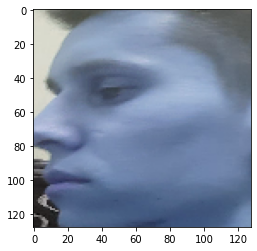

In [8]:
plt.imshow(image_list[2024])
label_list[2024]

### 2. Loading image from: casia-fasd + celeba + extra dataset

In [9]:
def get_ratio_bbox_and_image(full_img_path, bound_box_path):
    img = cv2.imread(full_img_path)
    real_h, real_w, _ = img.shape
    area_image = real_h * real_w
    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
    area_bbox = w1*h1
    return area_bbox / area_image

def standard_width_height_scaling(real_w, real_h, bbox0, bbox1, bbox2, bbox3):
    x1 = int(int(bbox0)*(float(real_w) / 224)) # bbox[0]
    y1 = int(int(bbox1)*(float(real_h) / 224)) # bbox[1]
    w1 = int(int(bbox2)*(float(real_w) / 224)) # bbox[2]
    h1 = int(int(bbox3)*(float(real_h) / 224)) # bbox[3]
    return x1, y1, w1, h1

def get_area_bbox_indices(bound_box_path, real_w, real_h):
    bound_box_read = open(bound_box_path, "r")
    bound_box_indices = list()
    for i in bound_box_read:
        bound_box_indices.append(i)
    bbox = bound_box_indices[0].split()
    x1, y1, w1, h1 = standard_width_height_scaling(real_w, real_h, bbox[0], bbox[1], bbox[2], bbox[3])
    return x1, y1, w1, h1

def get_padding_bbox_indices(x1, y1, w1, h1, real_w, real_h, ratio_bbox_and_image):
    x1_padding = x1 - int((w1) * (1+ratio_bbox_and_image))
    y1_padding = y1 - int((h1) * (1+ratio_bbox_and_image))
    w1_padding = w1 + int((w1) * (1+ratio_bbox_and_image))
    h1_padding = h1 + int((h1) * (1+ratio_bbox_and_image))
    if x1_padding < 0: 
        x1_padding = 0
    if y1_padding < 0:
        y1_padding = 0
    if w1_padding > real_w:
        w1_padding = real_w
    if h1_padding > real_h:
        h1_padding = real_h
    return x1_padding, y1_padding, w1_padding, h1_padding
    
def read_crop_img_with_bbox(full_img_path, bound_box_path):
    img = cv2.imread(full_img_path)
    real_w = img.shape[1]
    real_h = img.shape[0]
    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
    return x1, y1, w1, h1, img, real_w, real_h

In [10]:
bound_box_path = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train/1/spoof/000390_BB.txt'
bound_box_read = open(bound_box_path, "r")
bound_box_indices = list()
for i in bound_box_read:
    bound_box_indices.append(i)
bbox = bound_box_indices[0].split()
bbox

['46', '55', '93', '108', '0.99638236']

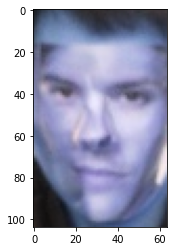

In [11]:
full_img_path = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train/10000/spoof/007425.jpg'
bound_box_path = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train/10000/spoof/007425_BB.txt'
img = cv2.imread(full_img_path)
real_h, real_w, _ = img.shape
#area_image = real_h * real_w
x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
area_bbox = w1*h1
#print(x1, y1, w1, h1, real_h, real_w, area_bbox,  area_image, area_bbox / area_image)
face_roi = img[y1:y1+h1, x1:x1+w1]
#face_roi = cv2.resize(img, (128,128))
plt.imshow(face_roi)

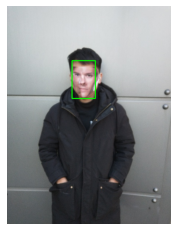

In [12]:
cv2.rectangle(img, (x1, y1), (x1+w1, y1+h1), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [13]:
count_live = 0
count_spoof = 0
count_limit_live = 2500
count_limit_spoof = 2500

for file in os.listdir(rootdir_train):
    d = os.path.join(rootdir_train, file)
    if os.path.isdir(d):
        for e in os.listdir(d):
            # e is "live" of "spoof"
            imgs_path = d + '/' + e + '/'
            for img_path in os.listdir(imgs_path):
                if (img_path.endswith(".jpg")):
                    full_img_path = imgs_path + img_path
                    bound_box_path = full_img_path[0:-4] + '_BB.txt'
                    
                    img = cv2.imread(full_img_path)
                    real_h, real_w, _ = img.shape
                    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
                    
                    try:
                        if (e == 'live' and count_live >= count_limit_live) or (e == 'spoof' and count_spoof >= count_limit_spoof):
                            continue
                        face_roi = img[y1:y1+h1, x1:x1+w1]
                        face_roi = cv2.resize(face_roi, dim)
                        image_list.append(face_roi)
                        
                        if e == 'live':
                            count_live = count_live + 1
                            label_list.append(1)
                        elif e == 'spoof':
                            count_spoof = count_spoof + 1
                            label_list.append(0)
                    except:
                        continue

                    if (count_live == count_limit_live and e == 'live') or (count_spoof == count_limit_spoof and e == 'spoof'):
                        break

            if count_live >= count_limit_live and count_spoof >= count_limit_spoof:
                break
    if count_live >= count_limit_live and count_spoof >= count_limit_spoof:
        print("DONE Extract")
        break

DONE Extract


In [14]:
for label in os.listdir(train_dir):
    for file in os.listdir(os.path.join(train_dir,label)):
        for img in os.listdir(os.path.join(train_dir,label,file)):
            img = cv2.imread(os.path.join(train_dir,label,file,img))
            img = cv2.resize(img, (128,128))
            image_list.append(img)
            if label == 'real':
                label_list.append(1)
            else:
                label_list.append(0)

for label in os.listdir(test_dir):
    for file in os.listdir(os.path.join(test_dir,label)):
        for img in os.listdir(os.path.join(test_dir,label,file)):
            img = cv2.imread(os.path.join(test_dir,label,file,img))
            img = cv2.resize(img, (128,128))
            image_list.append(img)
            if label == 'real':
                label_list.append(1)
            else:
                label_list.append(0)

In [15]:
for file in os.listdir(train_color):
    img = cv2.imread(os.path.join(train_color,file))
    img = cv2.resize(img, (128,128))
    image_list.append(img)

    if 'real' in file :
        label_list.append(1)
    else:
        label_list.append(0)

for file in os.listdir(test_color):
    img = cv2.imread(os.path.join(test_color,file))
    img = cv2.resize(img, (128,128))
    image_list.append(img)

    if 'real' in file :
        label_list.append(1)
    else:
        label_list.append(0)

1


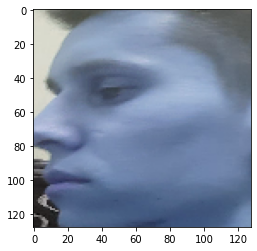

In [16]:
print(label_list[2024])
plt.imshow(image_list[2024])

In [17]:
X = np.array(image_list)
y = np.array(label_list)
X = X/255
X.shape, y.shape

((20422, 128, 128, 3), (20422,))

In [18]:
unique, counts = np.unique(label_list, return_counts=True)
dict(zip(unique, counts))

{0: 10623, 1: 9799}

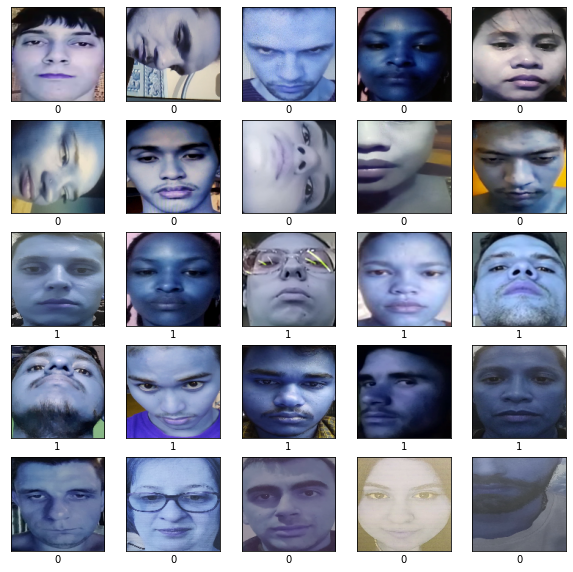

In [23]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i*200])
    plt.xlabel(str(y[i*200]))
plt.show()

In [24]:
def count_labels(label, name):
    unique, counts = np.unique(label, return_counts=True)
    print(f'Count label of {name}: {dict(zip(unique, counts))}')

In [25]:
print(X.shape)
print(y.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X, y,stratify=y, test_size=0.3, random_state=42, shuffle = True)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid,stratify=y_valid, test_size=0.5, random_state=42, shuffle = True)
print(f'Training dataset size of X_train: {len(X_train)}')
print(f'Testing dataset size of X_test: {len(X_test)}')
print(f'Validation dataset size of X_valid: {len(X_valid)}')
print(f'Testing dataset size of y_train: {len(y_train)}')
print(f'Testing dataset size of y_test: {len(y_test)}')
print(f'Validation dataset size of y_valid: {len(y_valid)}')
count_labels(y_train, name='y_train')
count_labels(y_test, name='y_test')
count_labels(y_valid, name='y_valid')

(20422, 128, 128, 3)
(20422,)
Training dataset size of X_train: 14295
Testing dataset size of X_test: 3064
Validation dataset size of X_valid: 3063
Testing dataset size of y_train: 14295
Testing dataset size of y_test: 3064
Validation dataset size of y_valid: 3063
Count label of y_train: {0: 7436, 1: 6859}
Count label of y_test: {0: 1594, 1: 1470}
Count label of y_valid: {0: 1593, 1: 1470}


# BUILD AND TRAIN MODEL

In [26]:
!pip install efficientnet

     |████████████████████████████████| 50 kB 6.0 MB/s  eta 0:00:01


In [27]:
from keras.applications import MobileNetV2
from efficientnet.tfkeras import EfficientNetB1,EfficientNetB0
from keras.layers import Input, Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.models import Model, Sequential

model_base = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(128,128,3))
model_base.trainable = True
model = Sequential()
model.add(model_base)
model.add(GlobalAveragePooling2D())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.summary()

27164672/27164032 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Functional) (None, 4, 4, 1280)        6575232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________

In [28]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-8)
model.compile(loss='binary_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])

In [29]:
batch_size = 64
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(X_train,y_train, batch_size=batch_size)

In [30]:
history = model.fit(train_generator, epochs=30, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[lrd])

Epoch 1/30
224/224 [==============================] - 83s 281ms/step - loss: 0.3590 - accuracy: 0.8372 - val_loss: 0.5863 - val_accuracy: 0.8681
Epoch 2/30
224/224 [==============================] - 59s 261ms/step - loss: 0.1228 - accuracy: 0.9587 - val_loss: 0.0836 - val_accuracy: 0.9687
Epoch 3/30
224/224 [==============================] - 59s 262ms/step - loss: 0.0700 - accuracy: 0.9788 - val_loss: 0.0623 - val_accuracy: 0.9781
Epoch 4/30
224/224 [==============================] - 59s 261ms/step - loss: 0.0636 - accuracy: 0.9803 - val_loss: 0.0893 - val_accuracy: 0.9722
Epoch 5/30
224/224 [==============================] - 59s 261ms/step - loss: 0.0470 - accuracy: 0.9839 - val_loss: 0.0796 - val_accuracy: 0.9794
Epoch 6/30
224/224 [==============================] - 59s 263ms/step - loss: 0.0394 - accuracy: 0.9867 - val_loss: 0.0430 - val_accuracy: 0.9869
Epoch 7/30
224/224 [==============================] - 59s 265ms/step - loss: 0.0442 - accuracy: 0.9858 - val_loss: 0.0298 - val_ac

In [45]:
model.save("./model_B1.h5")

# EVALUATION 

In [31]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

96/96 - 2s - loss: 0.0169 - accuracy: 0.9964


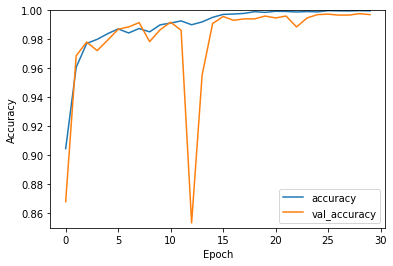

In [39]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.85, 1])
plt.legend(loc='lower right')

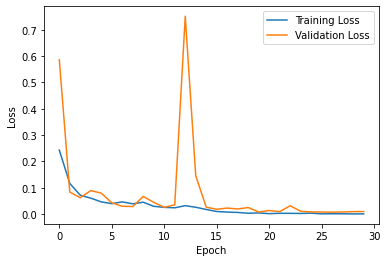

In [33]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

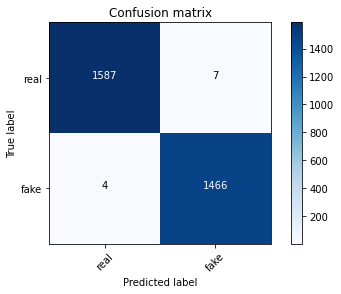

In [34]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['real', 'fake'])

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

y_pred_prob = model.predict(X_test)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

conf_matrix = confusion_matrix(y_test, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Precision: 0.9952
Recall: 0.9973
F1 Score: 0.9963
Confusion Matrix:
[[1587    7]
 [   4 1466]]
